# LSTM Twitter Sentiment Analysis

## Importing libraries

In [1]:
# install new libraries
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.5/637.5 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [2]:
# importing Libraries

# Library to interact with files and time operations
import os
import time
import warnings
warnings.filterwarnings('ignore')

# libraries for handling random values
import random

# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from itertools import product

# library for experiment tracking
import mlflow

# NLTK libraries
import nltk
from nltk import tokenize
from nltk.tokenize import WhitespaceTokenizer

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# library for Word2Vec model
from gensim.models import Word2Vec

# Libraries for deep learning using Pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Library for clearing Jupyter Notebook cell output
from IPython.display import clear_output

## Load the data

In [3]:
# copy the data from drive to google colab
!cp "/content/drive/MyDrive/Twitter_Sentiment_Analysis/training_processed_data.csv" "/content/"
!cp "/content/drive/MyDrive/Twitter_Sentiment_Analysis/SKIP_Word2Vec.model" "/content/"
!cp "/content/drive/MyDrive/Twitter_Sentiment_Analysis/CBOW_Word2Vec.model" "/content/"

In [4]:
# load the dataset into memory
dataset = pd.read_csv("/content/training_processed_data.csv") #, nrows = 500000)

In [5]:
# removing the null values
dataset.dropna(axis = 0, how = 'any', inplace = True)
dataset.isnull().sum()

,0
target,0
text,0


## Setting the seed for reproducibility

In [6]:
def set_seed(seed_value):
  # set python's random seed
  random.seed(seed_value)

  # set numpy's random seed
  np.random.seed(seed_value)

  os.environ['PYTHONHASHSEED'] = str(seed_value)
  # set Pytorch;s CPU seed
  torch.manual_seed(seed_value)
  # Set CuDNN deterministic mode (for further reproducibility)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  # Set PyTorch's GPU seed (if available)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

## Splitting the dataset into train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['target'], test_size = 0.2, random_state = 42)


## Data Vectorization

In [ ]:
# Define the path to pre-trained Word2Vec models (CBOW, Skipgram)
cbow_path = "/content/CBOW_Word2Vec.model"
sk_path = "/content/SKIP_Word2Vec.model"

# Load the models
cbow = Word2Vec.load(cbow_path)
sk = Word2Vec.load(sk_path)

               count      mean       std  min  25%  50%  75%   90%   95%   max
num_words  1572627.0  6.117865  3.492852  1.0  3.0  6.0  8.0  11.0  12.0  40.0


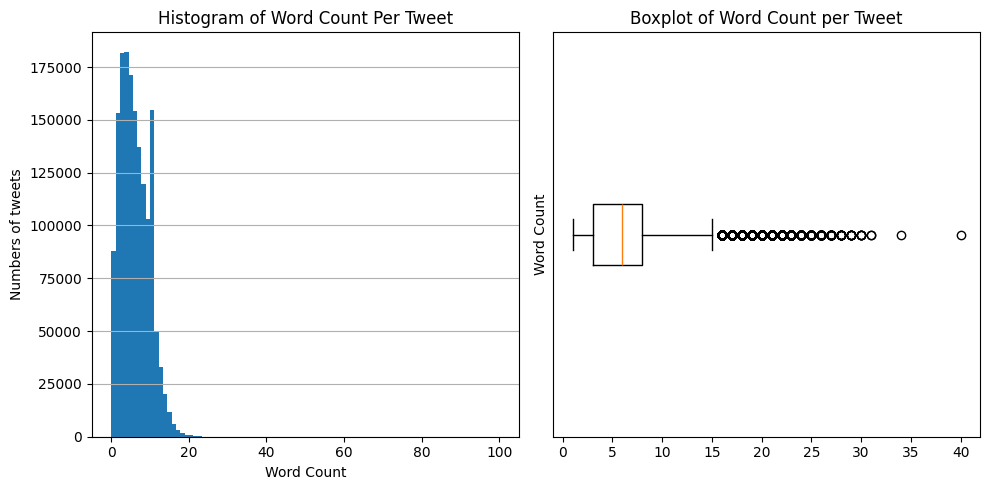

In [7]:
# Calculate the numbers of words in each tweet and store it in a new column 'num_words

dataset['num_words'] = dataset['text'].apply(lambda x: len(x.split(" ")))

# Generate descriptive statisitcs and add 90th and 95th percentiles
describe= pd.DataFrame(dataset['num_words'].describe()).T
percentile_90 = dataset['num_words'].quantile(0.9)
describe['90%'] = percentile_90
precentile_95 = dataset['num_words'].quantile(0.95)
describe['95%'] = precentile_95
describe = describe[[col for col in describe if col != 'max']+['max']]
print(describe)

# create subplots for histogram and boxplot
fig, (ax1, ax2) =plt.subplots(1, 2, figsize = (10,5))

# Histogram of word count per tweet
ax1.hist(dataset['num_words'], bins = 90, range = [0,100], histtype = 'stepfilled')
ax1.set_title("Histogram of Word Count Per Tweet")
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Numbers of tweets")
ax1.grid(axis = 'y')

# Boxplot of word count per tweet
ax2.boxplot(dataset['num_words'], vert= False)
ax2.set_title('Boxplot of Word Count per Tweet')
ax2.set_ylabel("Word Count")
ax2.set_yticks([])

# Adjust the layout
plt.tight_layout()
plt.show()